In [1]:
import pandas as pd
from hana_ml import dataframe as dfh

In [2]:
hana_cloud_endpoint="8e1a286a-21d7-404d-8d7a-8c77d2a77050.hana.trial-eu10.hanacloud.ondemand.com:443"

In [3]:
hana_cloud_host, hana_cloud_port=hana_cloud_endpoint.split(":")

cchc=dfh.ConnectionContext(port=hana_cloud_port,
                                         address=hana_cloud_host,
                                         user='HANAML',
                                         password='Super$ecr3t!',
                                         encrypt=True
                                        )

In [4]:
cchc.connection.isconnected()

True

## GeoPandas = Pandas + Geo processing and plotting

In [5]:
!pip install geopandas descartes

  Using cached geopandas-0.8.1-py2.py3-none-any.whl (962 kB)
  Using cached descartes-1.1.0-py3-none-any.whl (5.8 kB)


In [6]:
import geopandas

In [7]:
dfh_countries = cchc.table("TM_WORLD_BORDERS", geo_cols={"SHAPE":"4326"})

In [8]:
dfg_countries = geopandas.GeoDataFrame(dfh_countries.collect(), 
                                       geometry='SHAPE', crs="EPSG:4326"
                                      )

In [9]:
dfg_countries.dtypes

FIPS           object
ISO2           object
ISO3           object
UN              int64
NAME           object
AREA            int64
POP2005         int64
REGION          int64
SUBREGION       int64
LON            object
LAT            object
SHAPE        geometry
dtype: object

In [10]:
print(type(dfg_countries))
print(type(dfg_countries.LON))
print(type(dfg_countries.SHAPE))

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'pandas.core.series.Series'>
<class 'geopandas.geoseries.GeoSeries'>


## Visualize countries

<AxesSubplot:>

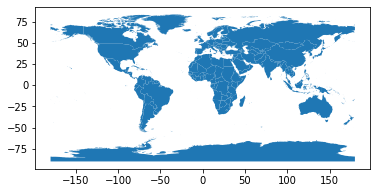

In [11]:
dfg_countries.plot()

In [12]:
import matplotlib.pyplot as plt

print(plt.rcParams.get('figure.figsize'))

[6.0, 4.0]


<AxesSubplot:>

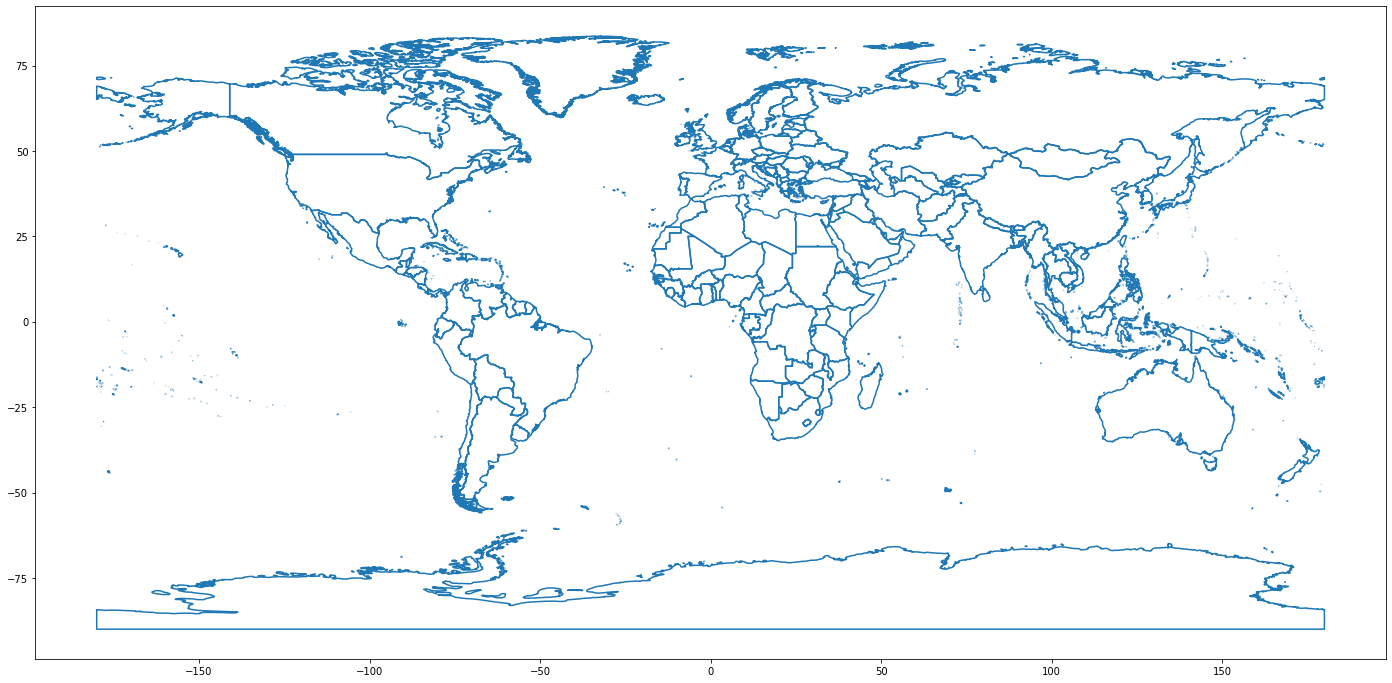

In [14]:
dfg_countries.boundary.plot(figsize=(26, 12))

In [15]:
plt.rcParams["figure.figsize"] = [26, 12]

<AxesSubplot:>

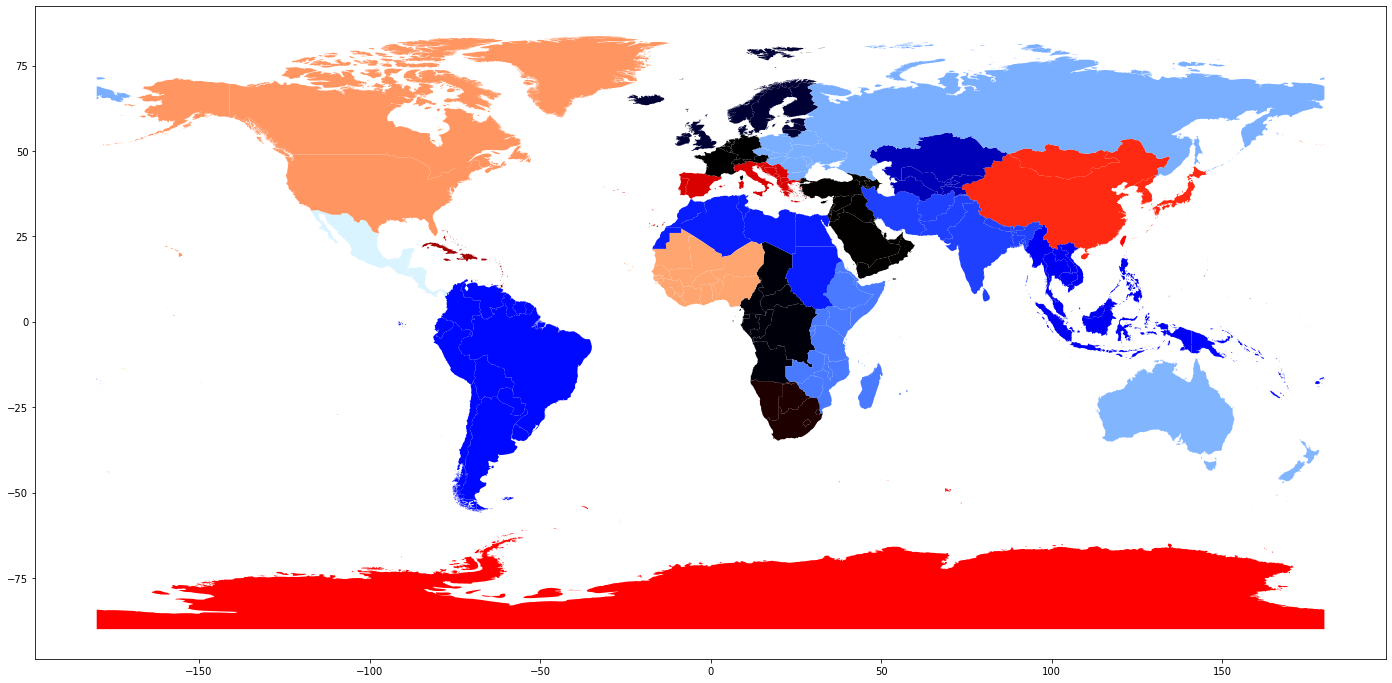

In [16]:
dfg_countries.plot(column="SUBREGION", cmap='flag')

<AxesSubplot:>

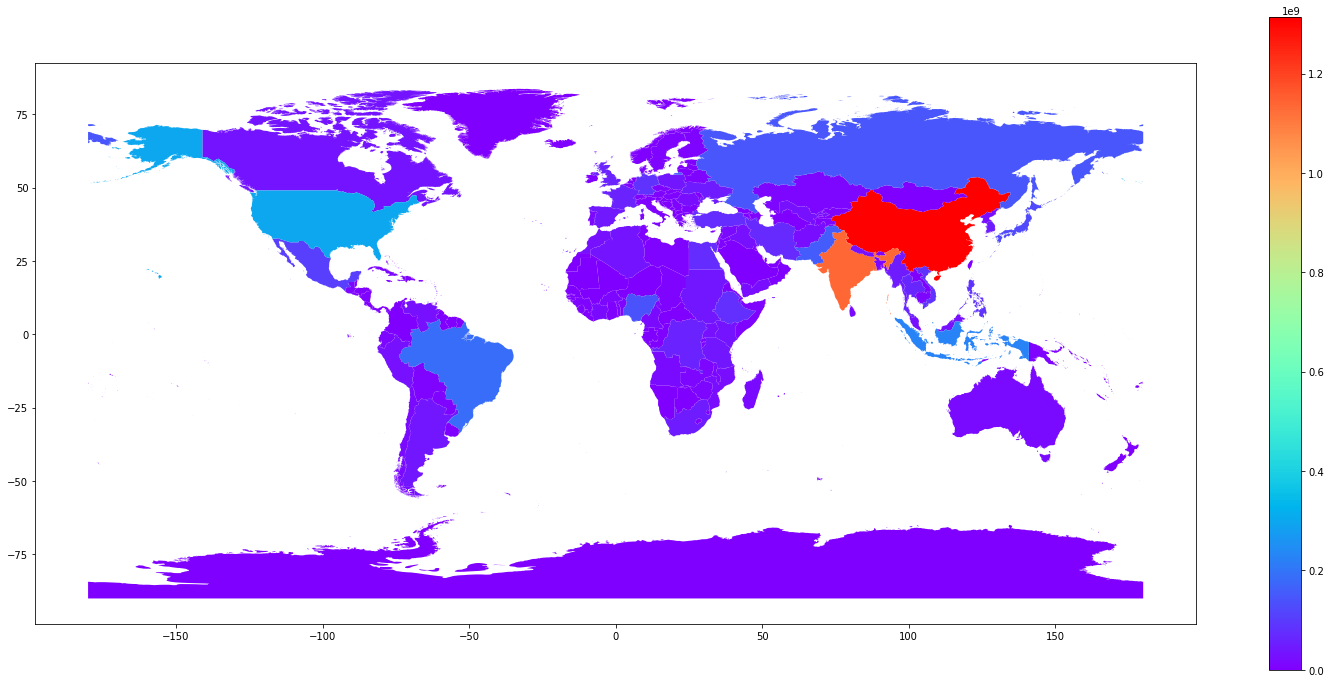

In [17]:
dfg_countries.plot(column="POP2005", cmap='rainbow', legend=True)

##### https://matplotlib.org/tutorials/colors/colormaps.html

## Visualize airport locations

In [18]:
dfh_ports = cchc.table("PORTS", geo_cols={"POINT_LON_LAT_GEO":"4326"}).select('CODE','POINT_LON_LAT_GEO')

<AxesSubplot:>

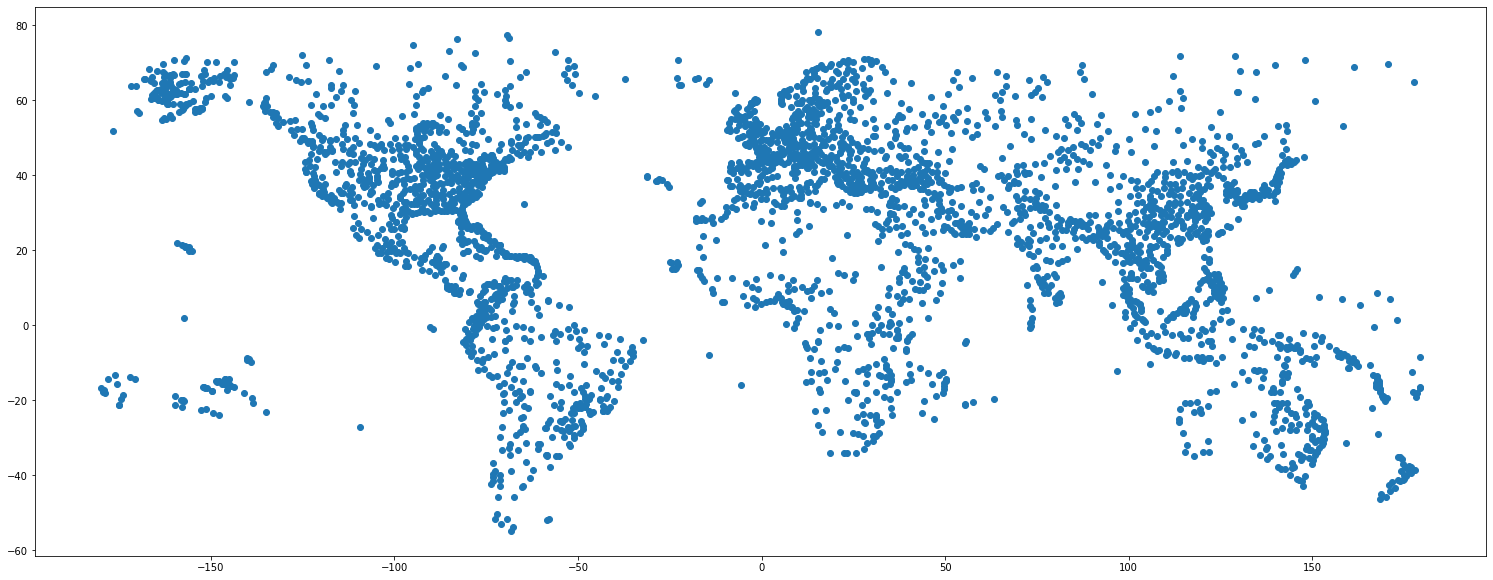

In [19]:
geopandas.GeoDataFrame(
    dfh_ports.collect(), 
    geometry='POINT_LON_LAT_GEO', crs="EPSG:4326"
).plot()

In [20]:
dfh_ports_pl = (dfh_ports
                .alias('P')
                .join(dfh_countries.filter("NAME='Poland'").alias('C'),
                      condition='P.POINT_LON_LAT_GEO.ST_CoveredBy(C.SHAPE)=1',
                      select=["P.*"]
                     )
               )

In [21]:
dfg_ports_pl = geopandas.GeoDataFrame(dfh_ports_pl.collect(), 
                                      geometry='POINT_LON_LAT_GEO', crs="EPSG:4326"
                                     )

<AxesSubplot:>

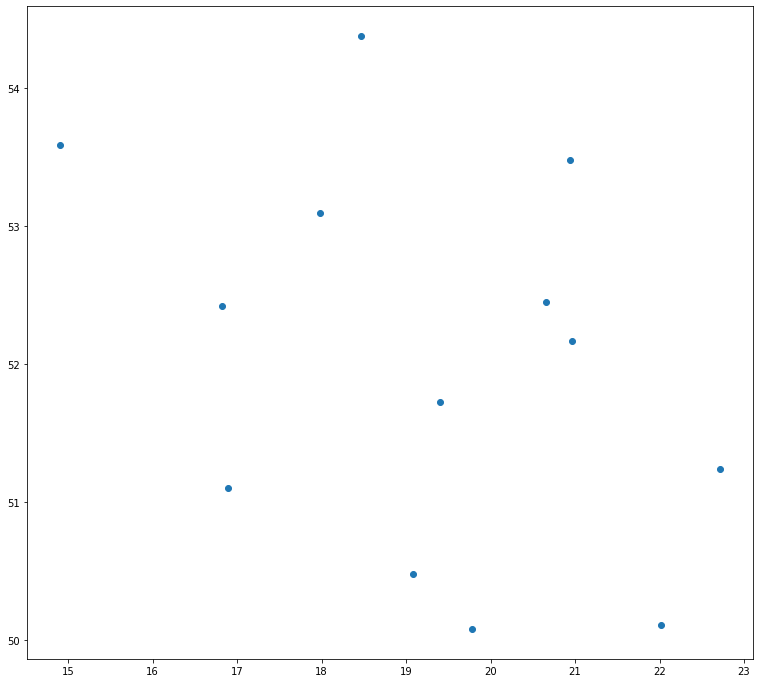

In [22]:
dfg_ports_pl.plot()

In [ ]:
dfg_ports_pl.columns

0     Annotation(18.4662, 54.3776, 'GDN')
1     Annotation(17.9777, 53.0968, 'BZG')
2     Annotation(14.9022, 53.5847, 'SZZ')
3     Annotation(19.3981, 51.7219, 'LCJ')
4     Annotation(20.6518, 52.4511, 'WMI')
5        Annotation(22.019, 50.11, 'RZE')
6     Annotation(20.9377, 53.4819, 'SZY')
7     Annotation(20.9671, 52.1657, 'WAW')
8       Annotation(19.08, 50.4743, 'KTW')
9     Annotation(16.8858, 51.1027, 'WRO')
10    Annotation(19.7848, 50.0777, 'KRK')
11    Annotation(22.7136, 51.2403, 'LUZ')
12     Annotation(16.8263, 52.421, 'POZ')
dtype: object

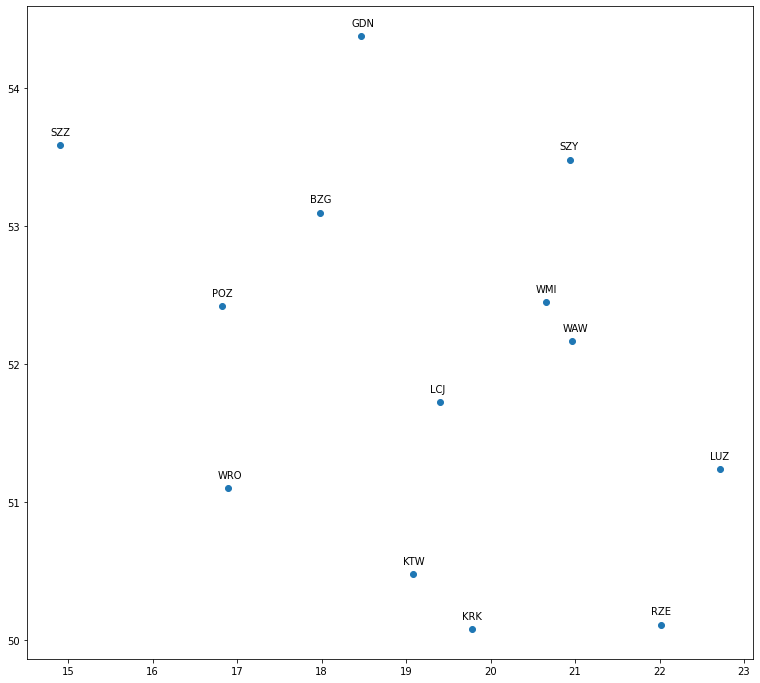

In [23]:
fig_port_pl=dfg_ports_pl.plot()

dfg_ports_pl.apply(
    lambda port: fig_port_pl.annotate(
        port.CODE, 
        xy=port.POINT_LON_LAT_GEO.coords[0], 
        xytext=(-10, 10), textcoords="offset points"
    ), axis=1
)

In [24]:
dfg_poland = geopandas.GeoDataFrame(dfh_countries.filter("ISO2='PL'").collect(),
                                    geometry='SHAPE', crs="EPSG:4326"
                                   )

<AxesSubplot:>

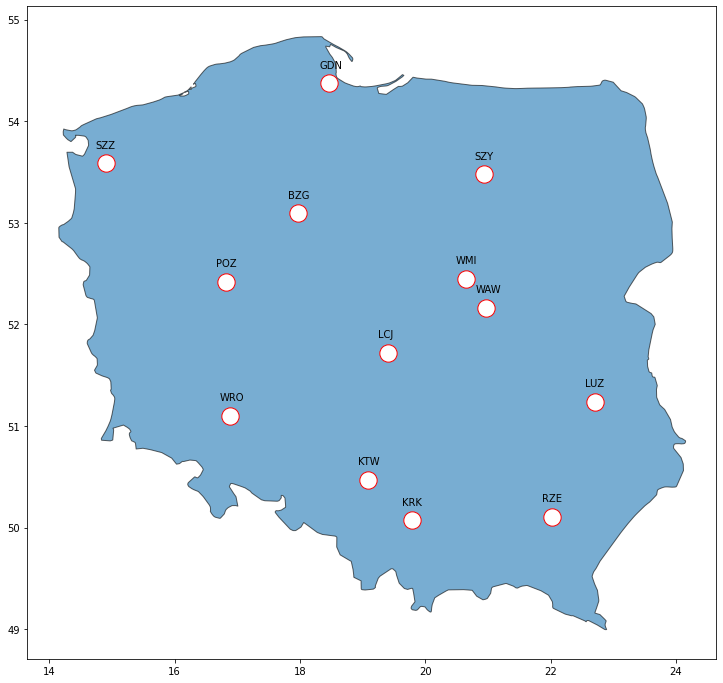

In [25]:
fig_port_pl=dfg_ports_pl.plot(color='w', edgecolor='r', markersize=300)

dfg_ports_pl.apply(lambda port: fig_port_pl.annotate(port.CODE, xy=port.POINT_LON_LAT_GEO.coords[0], xytext=(-10, 15), textcoords="offset points"), axis=1)

dfg_poland.plot(ax=fig_port_pl, alpha=0.6, edgecolor='k', zorder=0)

## Maps background

In [26]:
!pip install contextily

  Using cached contextily-1.0.1-py3-none-any.whl (23 kB)


In [27]:
import contextily as ctx

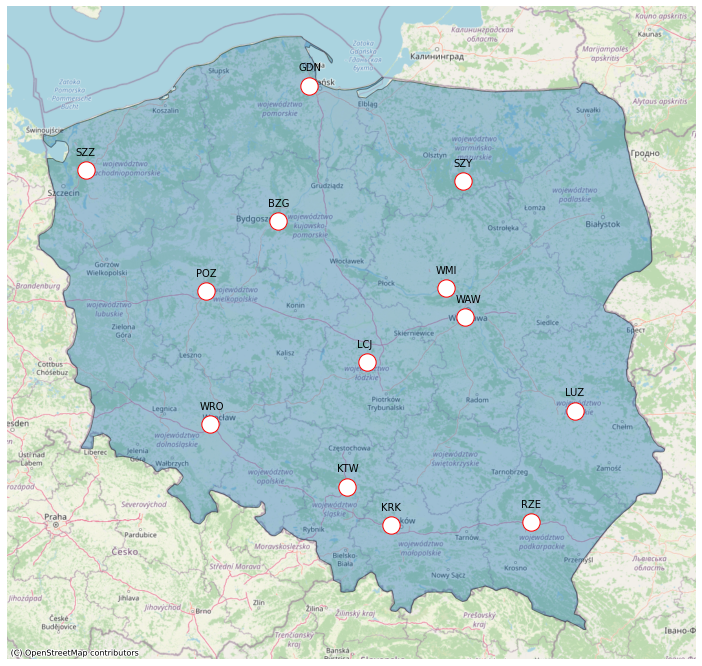

In [28]:
fig_port_pl=dfg_ports_pl.to_crs(epsg=3857).plot(alpha=1, color='w', edgecolor='r', markersize=300, zorder=2)

dfg_ports_pl.to_crs(epsg=3857).apply(lambda port: fig_port_pl.annotate(port.CODE, xy=port.POINT_LON_LAT_GEO.coords[0], xytext=(-10, 15), textcoords="offset points"), axis=1)

dfg_poland.to_crs(epsg=3857).plot(ax=fig_port_pl, alpha=0.4, edgecolor='k', zorder=1)
fig_port_pl.set_axis_off()

ctx.add_basemap(fig_port_pl, source=ctx.providers.OpenStreetMap.Mapnik)

## Spatial clustering example: Voronoi cells

In [29]:
country_iso2='PL'

sql_3857='''
SELECT 
	p."POINT_LON_LAT_GEO".ST_Transform(3857) AS "PORTGEO",
	ST_VoronoiCell(p."POINT_LON_LAT_GEO".ST_Srid(0), 30).ST_Srid(4326).ST_Intersection(wb."SHAPE").ST_Transform(3857) OVER () AS "CELL"
FROM "PORTS" p
JOIN "TM_WORLD_BORDERS" wb
ON p."POINT_LON_LAT_GEO".ST_COveredBy(wb."SHAPE")=1
WHERE wb."ISO2" ='{}'
'''.format(country_iso2)

In [30]:
dfp_ports_pl_voronoi = cchc.sql(
    sql_3857, geo_cols=['CELL','PORTGEO'], 
    srid=3857
).collect()

dfg_ports_pl_voronoi = geopandas.GeoDataFrame(
    dfp_ports_pl_voronoi, 
    geometry='CELL', crs="EPSG:3857"
)

<AxesSubplot:>

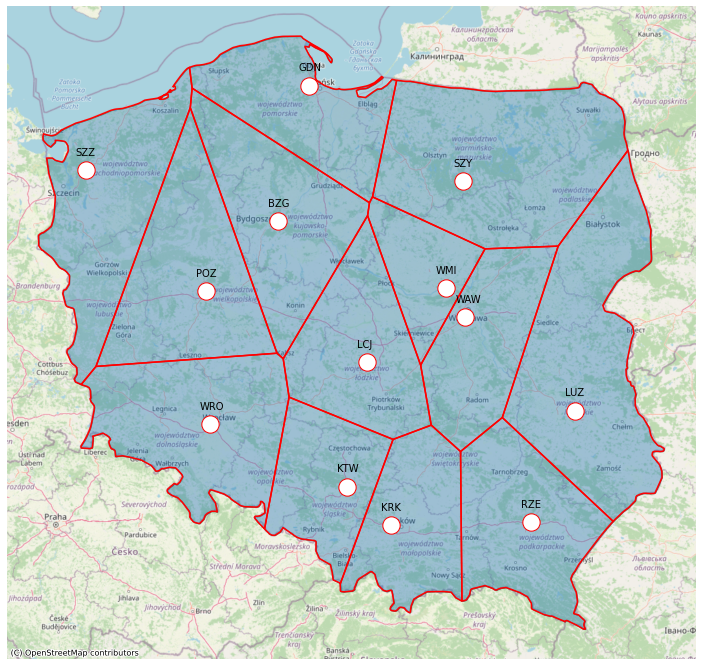

In [31]:
fig_port_pl=dfg_ports_pl.to_crs(epsg=3857).plot(alpha=1, color='w', edgecolor='r', markersize=300, zorder=3)

dfg_ports_pl.to_crs(epsg=3857).apply(lambda port: fig_port_pl.annotate(port.CODE, xy=port.POINT_LON_LAT_GEO.coords[0], xytext=(-10, 15), textcoords="offset points"), axis=1)

dfg_poland.to_crs(epsg=3857).plot(ax=fig_port_pl, alpha=0.4, edgecolor='k', zorder=1)
fig_port_pl.set_axis_off()

ctx.add_basemap(fig_port_pl, source=ctx.providers.OpenStreetMap.Mapnik)

dfg_ports_pl_voronoi.boundary.plot(ax=fig_port_pl, edgecolor='r', 
                                   zorder=2
                                  )